Data from https://www.kaggle.com/wkirgsn/electric-motor-temperature

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn import linear_model

In [2]:
df = pd.read_csv('Dataset zips/electric-motor-temperature/pmsm_temperature_data.csv')

## Context

The dataset comprises several sensor data collected from a permanent magnet synchronous motor (PMSM) deployed on a test bench. The PMSM represents a german OEM's prototype model. Test bench measurements were collected by the LEA department at Paderborn University. This dataset is mildly anonymized.

All recordings are sampled at 2 Hz (once every half second). The dataset consists of multiple measurement sessions, which can be distinguished from each other by column "profile_id". A measurement session can last between one and six hours long.

The motor is excited by hand-designed driving cycles denoting a reference motor speed and a reference torque. Currents in d/q-coordinates (columns "i_d" and i_q") and voltages in d/q-coordinates (columns "u_d" and "u_q") are a result of a standard control strategy trying to follow the reference speed and torque. Columns "motor_speed" and "torque" are the resulting quantities achieved by that strategy, derived from set currents and voltages.

Most driving cycles denote random walks in the speed-torque-plane in order to imitate real world driving cycles to a more accurate degree than constant excitations and ramp-ups and -downs would.

The most interesting target features are rotor temperature ("pm"), stator temperatures ("stator_") and torque. Especially rotor temperature and torque are not reliably and economically measurable in a commercial vehicle. 

Being able to have strong estimators for the rotor temperature helps the automotive industry to manufacture motors with less material and enables control strategies to utilize the motor to its maximum capability.A precise torque estimate leads to more accurate and adequate control of the motor, reducing power losses and eventually heat build-up.

## Explorational Analysis

To start lets investigate the  columns and summarize their context.  

In [3]:
list(df.keys())

['ambient',
 'coolant',
 'u_d',
 'u_q',
 'motor_speed',
 'torque',
 'i_d',
 'i_q',
 'pm',
 'stator_yoke',
 'stator_tooth',
 'stator_winding',
 'profile_id']

**profile_id**: the id of the session

**u_q**: Voltage q-component.  The quadrature or out of phase voltage. 

**u_d**: Voltage d-component.  The in phase voltage.

**i_q**: Current q-component, quadrature or out of phase current.

**i_d**: Current d-component, in phase current.

**motor speed**: the rotational speed of the stator.

**torque**:  induced by current.

**ambient**: Temperature as measured by a thermal sensor located closely to the stator.

**coolant**: temperature of water. The motor is water cooled. Measurement is taken at outflow.

**pm**: Permanent Magnet surface temperature representing the rotor temperature. This was measured with an infrared sensor

**stator_yoke**: the center cylinder of the stator, temperature measured with a thermal sensor.

**stator_tooth**: the protrusions where the wire is wound, temperature measured with a thermal sensor.

**stator_winding**: the wires wound to make an electro magnet, temperature measured with a thermal sensor.

How many entries does the dataset have?

Do any of these columns have null values or unusual values (e.g. strings where there should be floats)?

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 998070 entries, 0 to 998069
Data columns (total 13 columns):
ambient           998070 non-null float64
coolant           998070 non-null float64
u_d               998070 non-null float64
u_q               998070 non-null float64
motor_speed       998070 non-null float64
torque            998070 non-null float64
i_d               998070 non-null float64
i_q               998070 non-null float64
pm                998070 non-null float64
stator_yoke       998070 non-null float64
stator_tooth      998070 non-null float64
stator_winding    998070 non-null float64
profile_id        998070 non-null int64
dtypes: float64(12), int64(1)
memory usage: 99.0 MB


There are 998070 total entries. No column has empty or null values.  All values are floats or integers.  

### Measurement Distributions

Next we plot the distribution of each measurement to determine if there are any unusual clumps of data or aberrant patterns.

The input values for voltage and current (u_q, u_d, i_q, i_d) will be interesting to investigate.  Ideally they will have a normal or flat distribution to be representative of all possible inputs. 

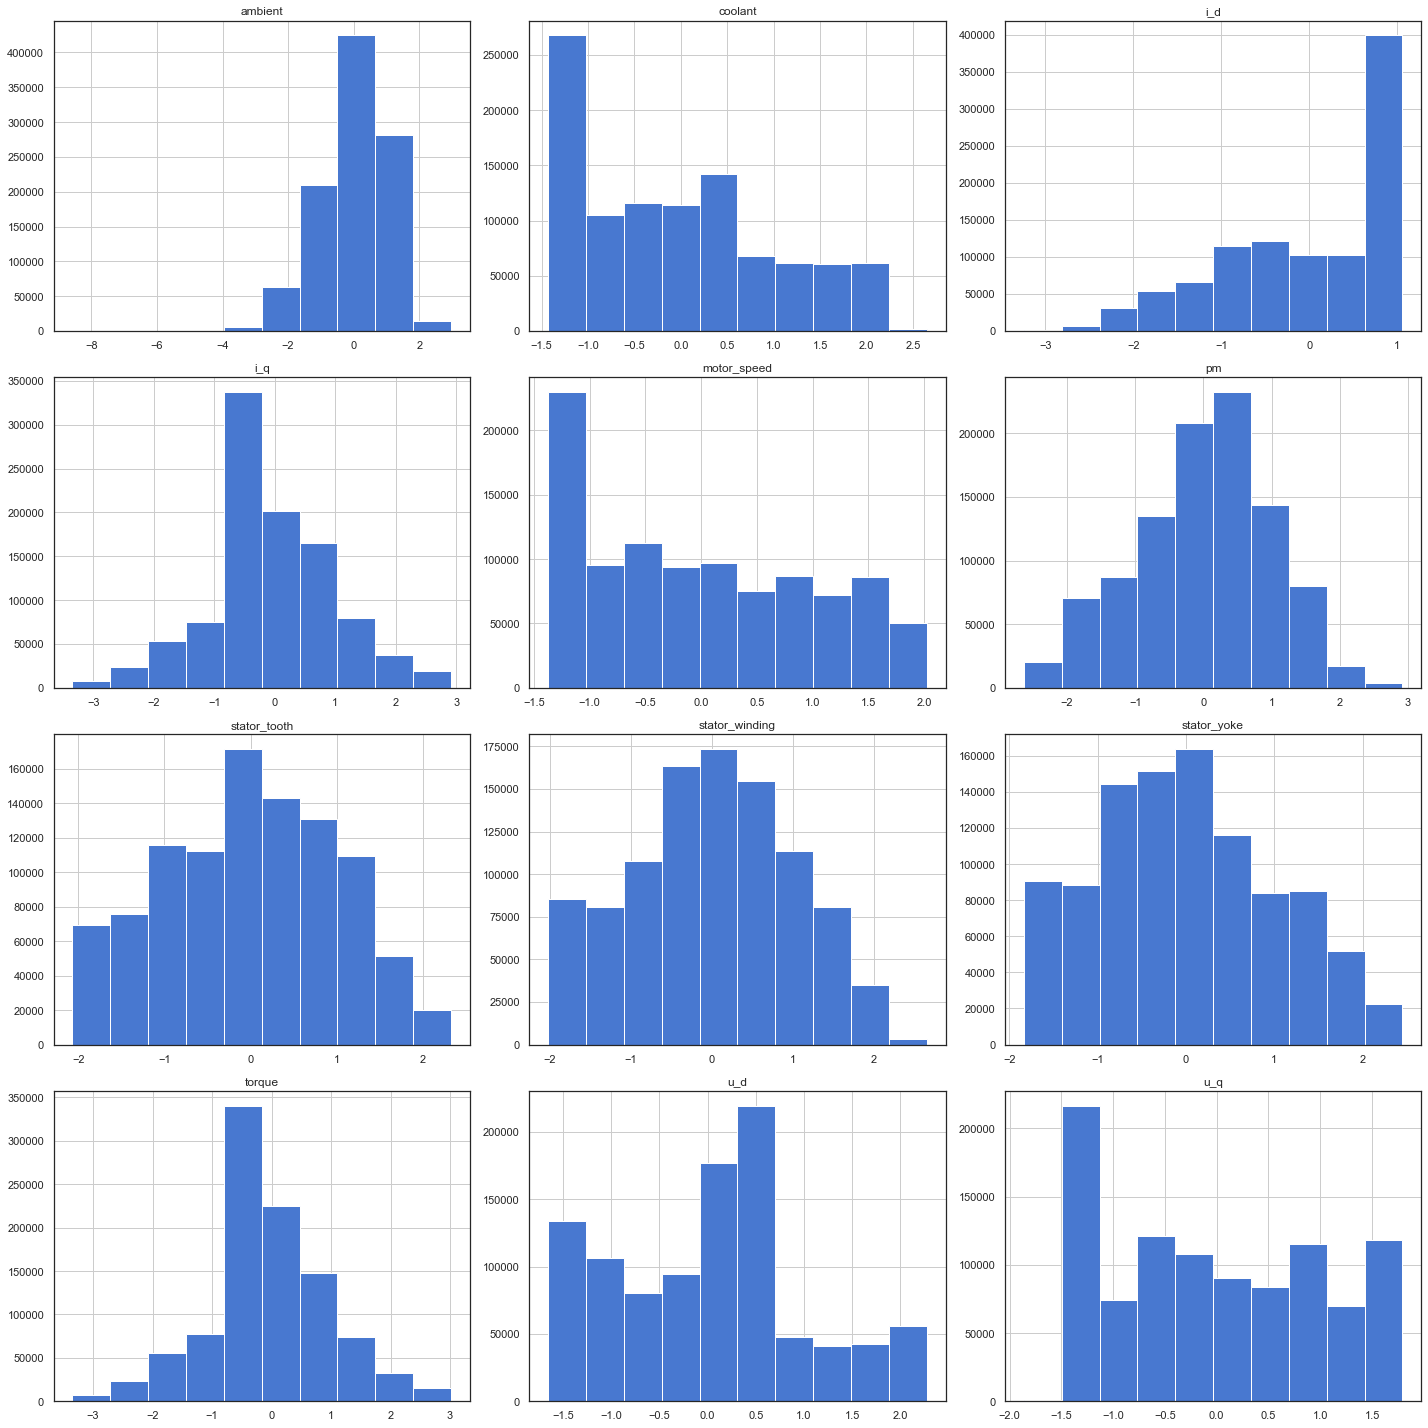

In [5]:
sns.set(style="white", palette="muted", color_codes=True)  #This style is a bit easier to read.

df.drop('profile_id', axis = 1).hist(figsize = (20,20))
plt.tight_layout()

In the histograms above, u_q and i_d each seem to have one group of values at the edge of their range with significantly more data points than average.

Lets look at u_q more closely.

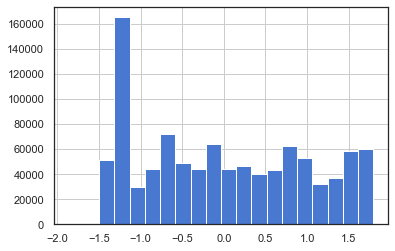

In [6]:
df['u_q'].hist(bins = 20)

There seem to be an unusually large number of u_q measurements within the range -1.2 to -1.5. 

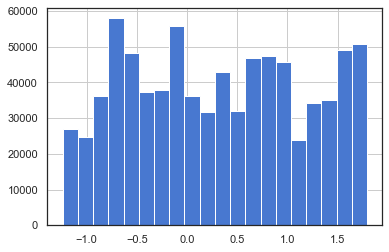

In [7]:
df['u_q'][(df['u_q'] >= -1.24)].hist(bins = 20)

Removing values below -1.24 results in a more even distribution.

### Question 1

Should we remove values of u_q that are overrepresented at the edge of the range?

Do datapoints with u_q values below -1.24 represent the overall population of values?  The quadrature current, i_q, in particular is associated with quadrature voltage, u_q.  

Thus, if these is a normal distribution of i_q values for datapoints where u_q is below -1.24, then we should keep those datapoints.  

Otherwise, if i_q values where u_q < -1.24 do not reflect the distribution of the full set of i_q values, then we should remove those datapoints.  


First lets examine a box and whisker plot of the i_q values.

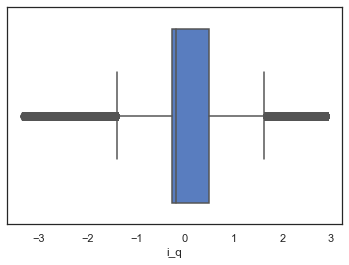

In [9]:
sns.boxplot(x = df['i_q'])

This distribution seems relatively normal, except for the abnormally small range for the 25% of datapoints below the median.  That range should be larger for a representative normal distribution.  

Lets see the distribution of i_q values when u_q is below -1.24

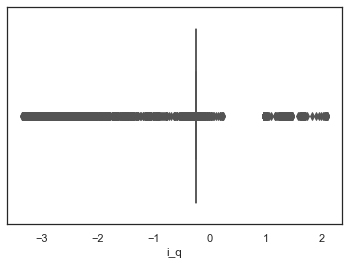

In [38]:
sns.boxplot(x = df['i_q'][df['u_q'] < -1.24])

We can see that the large majority of values are right on the median, this is not representative of the population of i_q values.

How about i_q values when u_q is above -1.24?

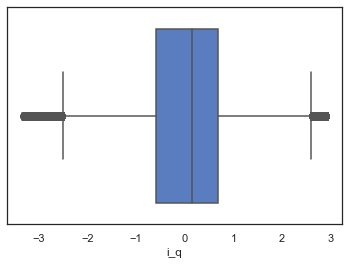

In [39]:
sns.boxplot(x = df['i_q'][df['u_q'] >= -1.24])

This distribution looks much more normal and does not have a clump of values just below the median.  

However, the box and whisker plot does not provide much detail.  Lets examine some histograms of the i_q values for different subsets of the data.

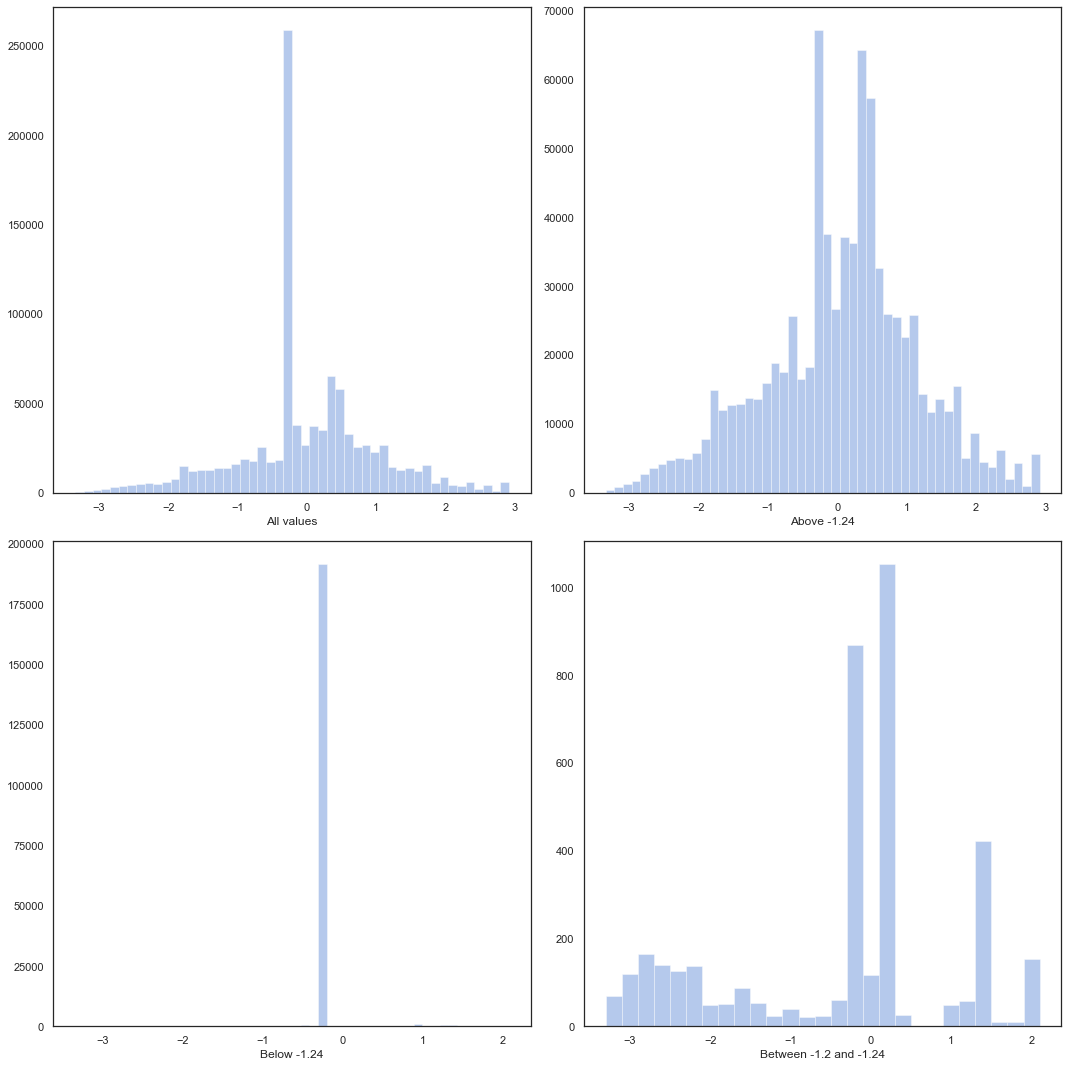

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15), sharex=False)

sns.distplot(df['i_q'], kde = False, color="b", ax=axes[0, 0], axlabel = 'All values') #all values

sns.distplot(df['i_q'][(df['u_q'] >= -1.24)], kde = False, color="b", ax=axes[0, 1], axlabel = 'Above -1.24') #values above -1.24, should be normal and high var

sns.distplot(df['i_q'][(df['u_q'] < -1.24)], kde = False, color="b", ax=axes[1, 0], axlabel = 'Below -1.24') #values below -1.24, should be low var

sns.distplot(df['i_q'][(df['u_q'] > -1.24)&(df['u_q'] < -1.2)], kde = False, color="b", ax=axes[1, 1], axlabel = 'Between -1.2 and -1.24') #values between -1.2 and 1.24, should still be high var

plt.tight_layout()

**Top Left**: The distribution of i_q values for all u_q values. There is an unusually large spike at approx -0.2

**Top Right**: The distribtuion of i_q values for u_q values above -1.24.  This distribution is much more normal.

**Bot Left**: The distribution of i_q values for u_q values below -1.24.  Almost all i_q values are the same.

**Bot Right**: The distribution of i_q values for u_q values between -1.2 and -1.24.  Since this distribution has a high variance we conclude that -1.24 is a good cutoff value.  

The full distribution of i_q values has an abberant spike at -0.2, removing datapoints with u_q below -1.24 results in a more normal distribution.  The vast majority of i_q values with u_q < -1.24 are all in a small range near -0.2 so they don't represent the population.  I determined -1.24 is a good cutoff point by showing that i_q values just above -1.24 have a wide distribution.  

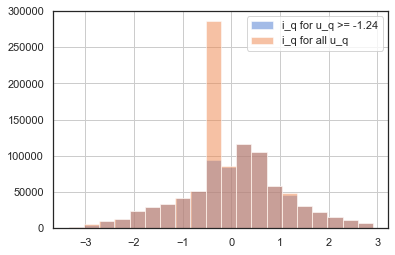

In [12]:
df['i_q'][(df['u_q'] >= -1.24)].hist(alpha = 0.5, bins = 20)
df['i_q'].hist(alpha = 0.5, bins = 20)
plt.legend(['i_q for u_q >= -1.24', 'i_q for all u_q'])

### Answer 1

We should remove values of u_q below -1.24 because there is a disproportionate number of measurements in that range and the corresponding i_q values are not normally distributed for u_q values below -1.24.

Since these are input values, this shows an error in the experimental setup.  Future trials should ensure that there is a representative spread of values for the current for each value of voltage.  

## A Representative Dataframe

Lets make a dataframe without u_q values below -1.24. 

When creating a new df from the original that adds new columns use .copy() to avoid 'SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame.'

In [13]:
#remove outliers
df_1 = df[df.u_q >= -1.24].copy()  #.copy() to avoid SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame.
df_1.reset_index(drop=True)
df_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 801465 entries, 18 to 997775
Data columns (total 13 columns):
ambient           801465 non-null float64
coolant           801465 non-null float64
u_d               801465 non-null float64
u_q               801465 non-null float64
motor_speed       801465 non-null float64
torque            801465 non-null float64
i_d               801465 non-null float64
i_q               801465 non-null float64
pm                801465 non-null float64
stator_yoke       801465 non-null float64
stator_tooth      801465 non-null float64
stator_winding    801465 non-null float64
profile_id        801465 non-null int64
dtypes: float64(12), int64(1)
memory usage: 85.6 MB


This reduced dataframe had approximately 200,000 fewer entries.

Lets generate some histograms to examine the distributions without the atypical datapoints.  

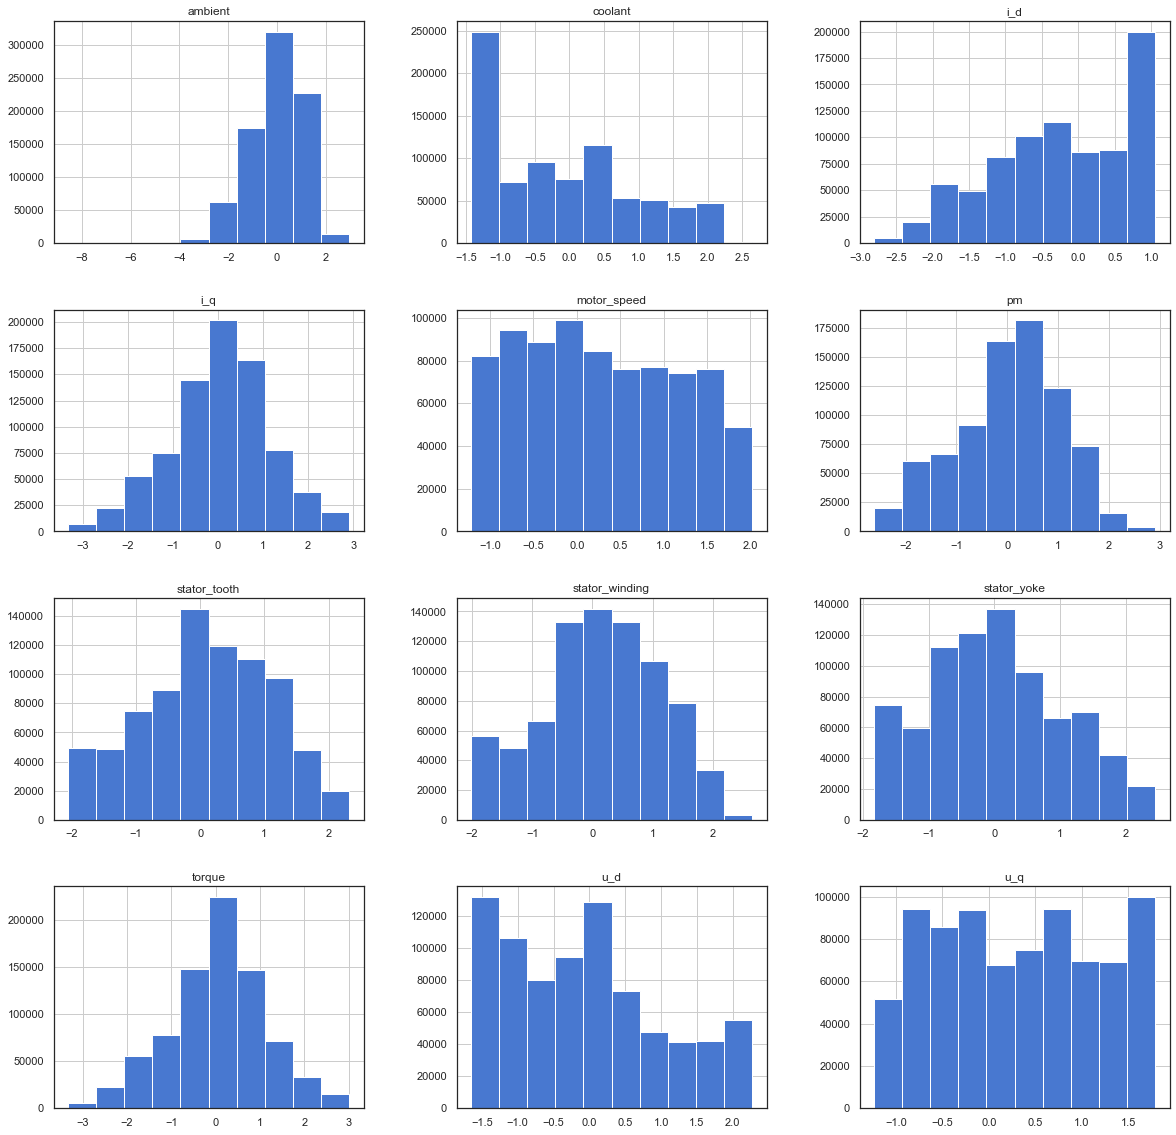

In [14]:
df_1.drop('profile_id', axis = 1).hist(figsize = (20,20))
plt.show()

Comparing these new histograms to the original histograms, we can see that the anomolies in u_q and i_q are both gone after removing u_q values below -1.24.  

The spike at the lower edge of motor speed is also gone.  

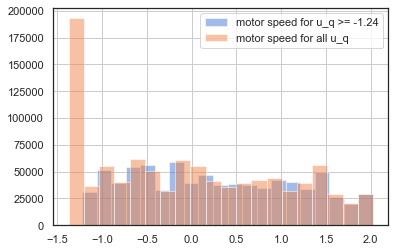

In [15]:
df['motor_speed'][(df['u_q'] >= -1.24)].hist(alpha = 0.5, bins = 20)
df['motor_speed'].hist(alpha = 0.5, bins = 20)
plt.legend(['motor speed for u_q >= -1.24', 'motor speed for all u_q'])

## Relative Relationships

We want to use the current or voltage input measurements to predict torque, motor speed, or a temperature reading.  Lets see if there is any pair of measurements that exhibits an obvious correlation.

In [16]:
df_1.drop(['profile_id', ], axis = 1).corr()

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding
ambient,1.000000,0.475607,0.188631,0.197468,0.174690,-0.262134,-0.052041,-0.260582,0.533126,0.512386,0.470799,0.373831
coolant,0.475607,1.000000,0.177767,0.146175,0.054044,-0.192758,0.056328,-0.190339,0.469498,0.887609,0.718742,0.544274
u_d,0.188631,0.177767,1.000000,0.089792,-0.175270,-0.820820,0.324523,-0.795803,-0.074692,0.060362,-0.035893,-0.116667
u_q,0.197468,0.146175,0.089792,1.000000,0.553040,-0.156367,0.180043,-0.140327,0.077658,0.084969,0.029255,-0.075573
motor_speed,0.174690,0.054044,-0.175270,0.553040,1.000000,-0.070641,-0.620378,-0.091219,0.383471,0.189628,0.291779,0.308522
torque,-0.262134,-0.192758,-0.820820,-0.156367,-0.070641,1.000000,-0.207600,0.996676,-0.092964,-0.111200,-0.039912,0.053973
i_d,-0.052041,0.056328,0.324523,0.180043,-0.620378,-0.207600,1.000000,-0.169253,-0.323499,-0.182699,-0.364244,-0.507312
i_q,-0.260582,-0.190339,-0.795803,-0.140327,-0.091219,0.996676,-0.169253,1.000000,-0.106916,-0.119166,-0.055804,0.031916
pm,0.533126,0.469498,-0.074692,0.077658,0.383471,-0.092964,-0.323499,-0.106916,1.000000,0.725077,0.803093,0.760933
stator_yoke,0.512386,0.887609,0.060362,0.084969,0.189628,-0.111200,-0.182699,-0.119166,0.725077,1.000000,0.953901,0.850887


Many of the values in the correlation chart above are close to 0 implying no correlation between those variables.  

However, some standouts are i_q vs torque at 0.99, u_d vs torque at -0.82, i_q vs motor speed at -0.62,  and coolant vs stator_yoke at 0.88. 

Additionally, the stator temperatures all have correlations close to one when compared to each other. This is likely due to the fact that they are close together or connected in the motor and thus conduct heat to each other.  

Lets examine these correlations in more detail using a pair grid and a heat map.  

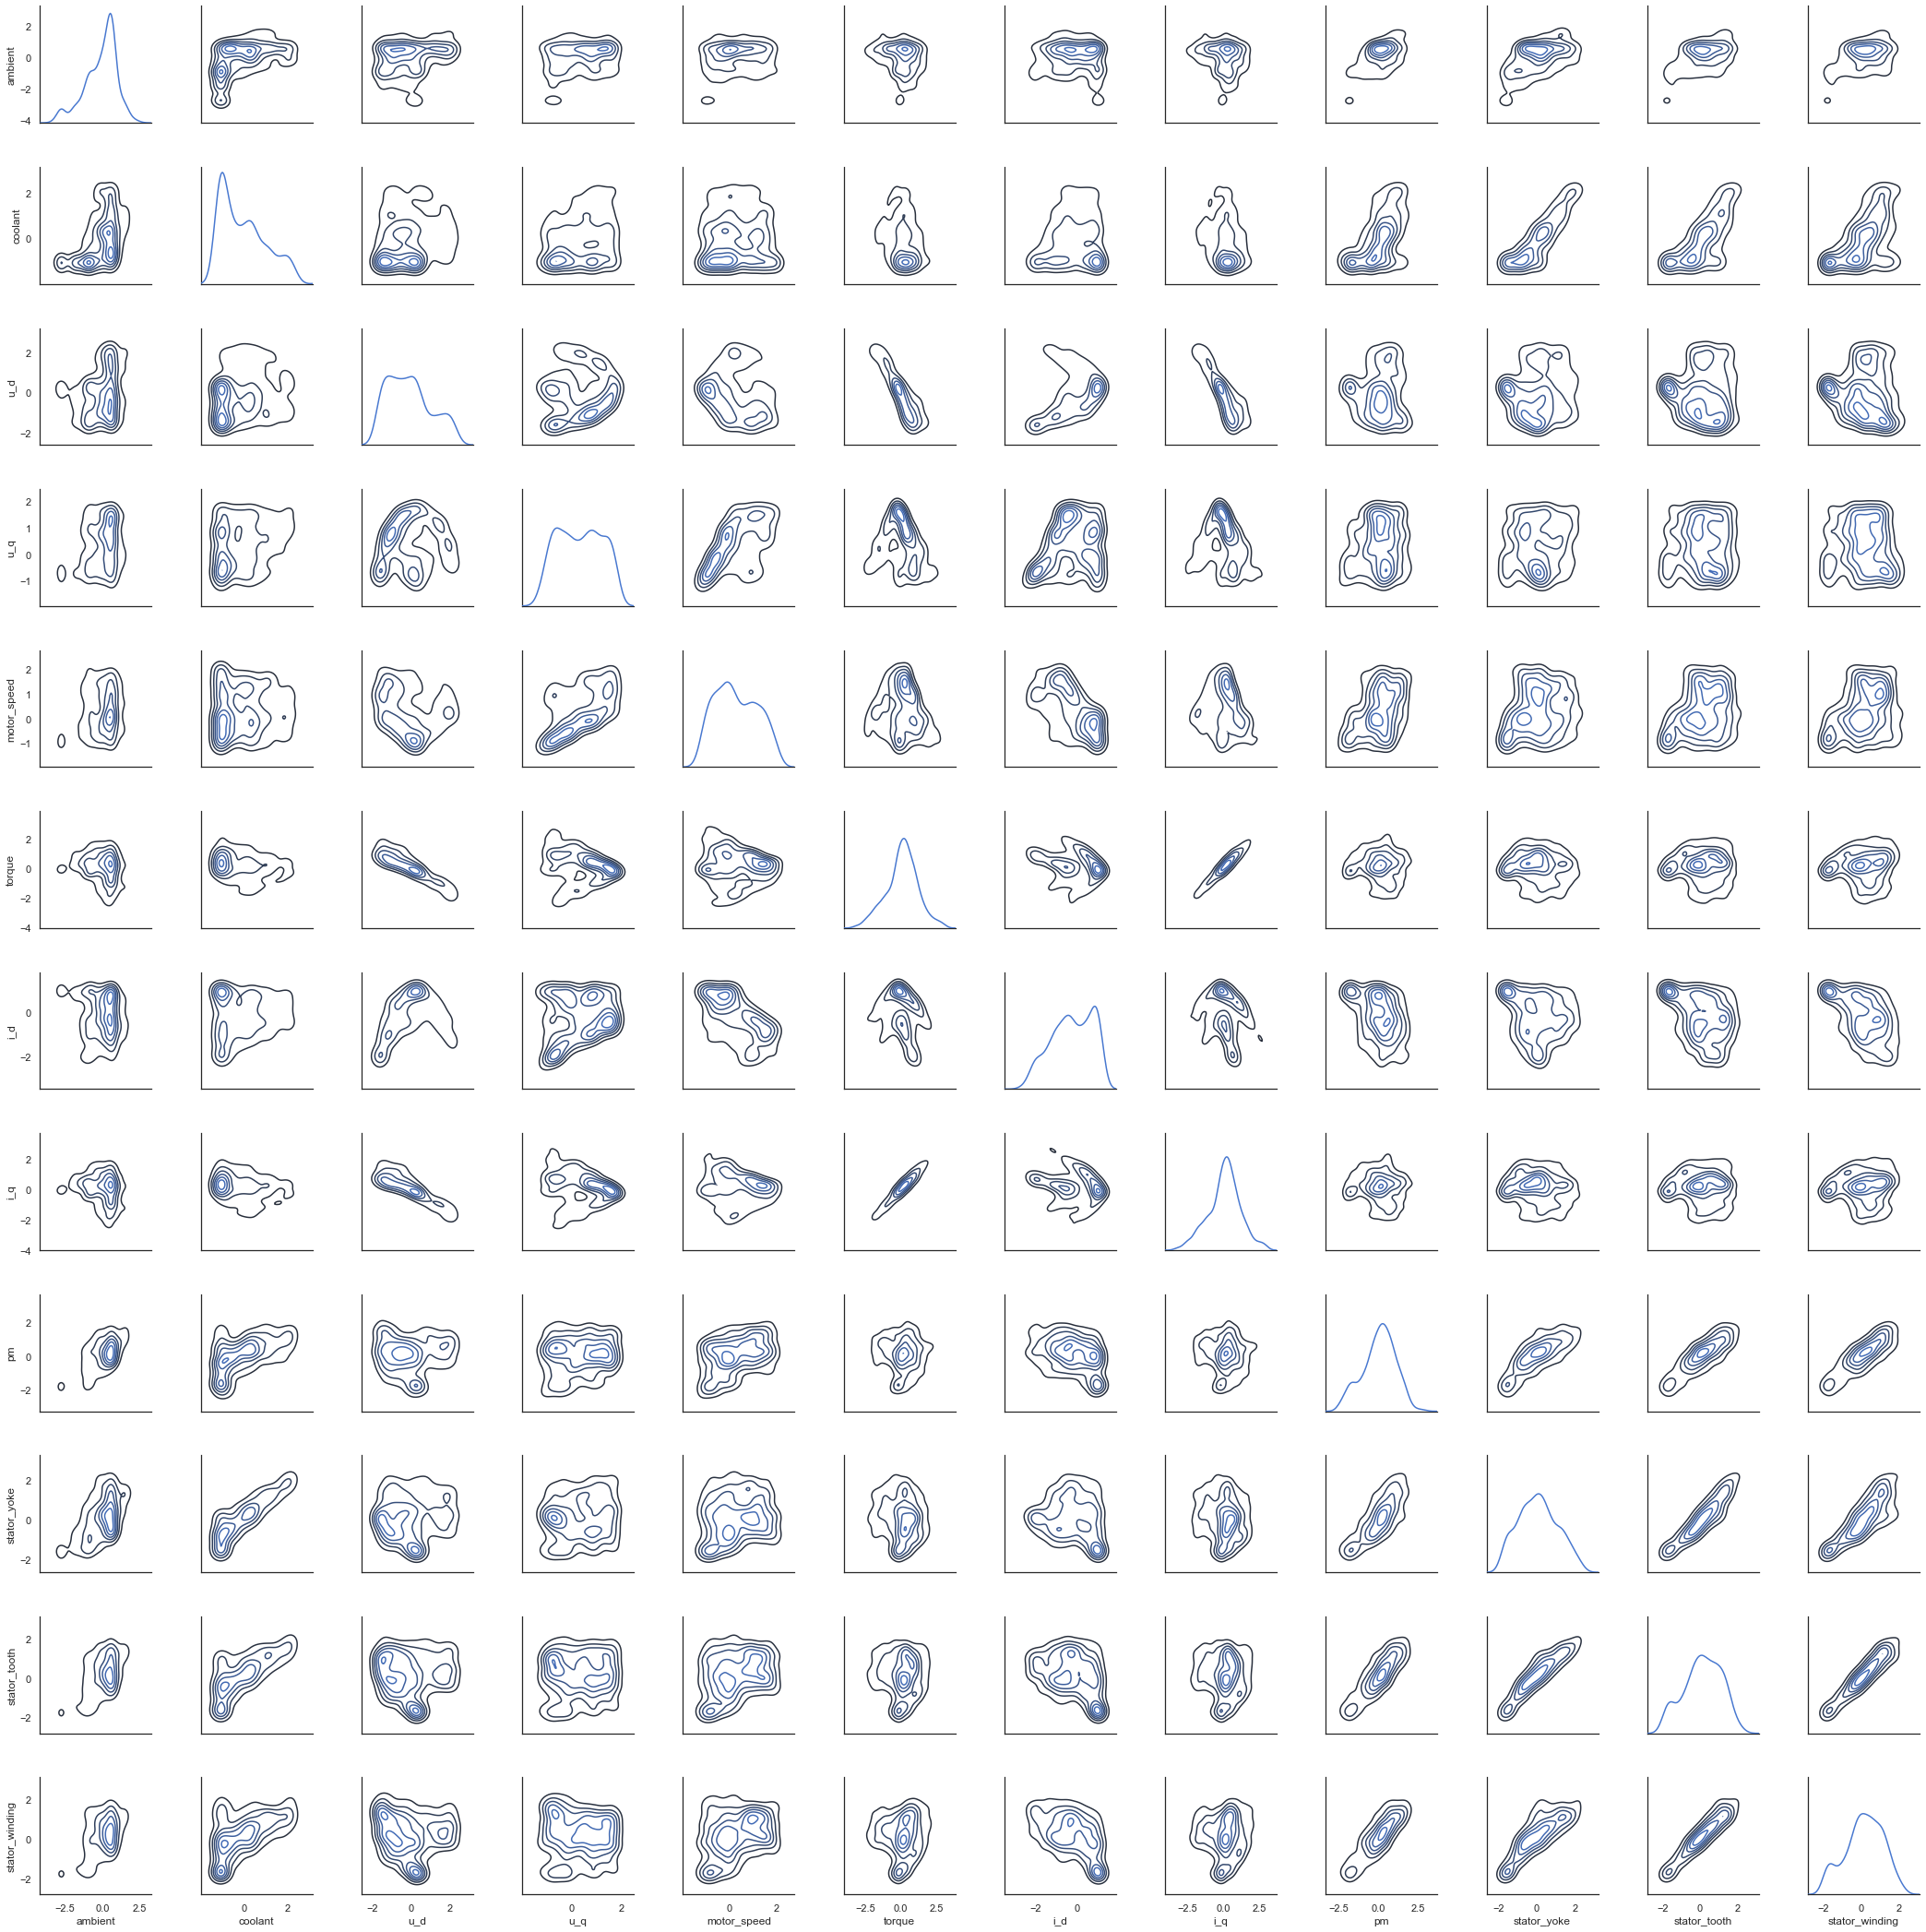

In [17]:
matplotlib.rcParams.update({'font.size': 35})
g_1 = sns.PairGrid(df_1.drop(['profile_id'], axis = 1).sample(frac=0.001)) #sample 0.1% of the data to reduce runtime
g_1.map_diag(sns.kdeplot) #put kde plots on the diagonal
g_1.map_offdiag(sns.kdeplot, n_levels=6);
#adapted code from kirgsn

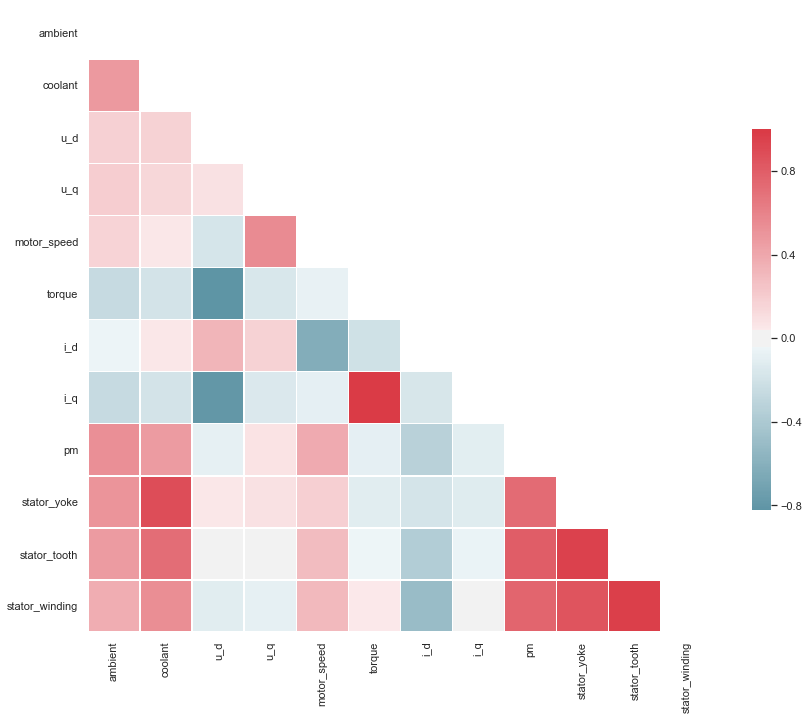

In [18]:
# Generate a mask for the upper triangle
mask = np.zeros_like(df_1.drop(['profile_id'], axis = 1).corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

plt.figure(figsize=(14,14))
sns.heatmap(df_1.drop(['profile_id'], axis = 1).corr(), mask=mask, cmap= cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

#adapted code from kirgsn

Some interesting correlations:

torque vs i_q: Strong positive correlation.

torque vs u_d: Moderate negative correlation.

motor speed vs u_q: Slight positive correlation.

motor speed vs i_d: Slight negative correlation

coolant vs stator_yoke: Strong positive correlation.

We will select some of these correlations to examine in detail below.  


## Question 2:

Which is a better predictor of torque, i_q or u_d? 

Null Hypothesis: The r squared values of the line of best fit for torque vs i_q is not close to one and thus the line is not a good approximation of the torque values.

Lets first examine these columns.

In [19]:
df_1[['i_q', 'u_d', 'torque']].describe()

,i_q,u_d,torque
count,801465.000000,801465.000000,801465.000000
mean,0.059317,-0.069924,0.060052
std,1.094655,1.095418,1.093223
min,-3.330740,-1.655373,-3.341182
25%,-0.581947,-1.037907,-0.572516
50%,0.153920,-0.123428,0.134250
75%,0.689024,0.593734,0.727128
max,2.914185,2.274734,3.016971


The means are close to 0, and the standard deviations are close to 1.  There are no standard deviations that are large, they are all equal and close to 1.  There are no datapoints beyond 3 standard deviations from the mean.  Over 50% of the datapoints are within one stndard deviation of the mean.

In [20]:
df[['torque', 'i_q', 'u_d']].corr()

,torque,i_q,u_d
torque,1.000000,0.996560,-0.821325
i_q,0.996560,1.000000,-0.796586
u_d,-0.821325,-0.796586,1.000000


Torque appears to have a strong linear relationship to i_q with a slope close to 1.   

Using linear regression, we can plot the line of best fit.  

(-3.5, 3.5)

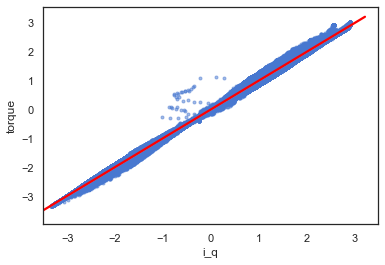

In [21]:
sns.regplot(x = 'i_q', y = 'torque', data = df_1, scatter = True, scatter_kws = {'alpha': 0.5}, line_kws = {'color': 'red'}, marker = '.')
plt.xlim(-3.5, 3.5)

The scatter plot obove shows the datapoints mostly fit within a small band.  The red line of best fit well describes the datapoints and looks to be a good predictor of future values.  The only outliers appear near i_q values just below 0 and seem to be slighly higher values of torque than the majority of datapoints.  

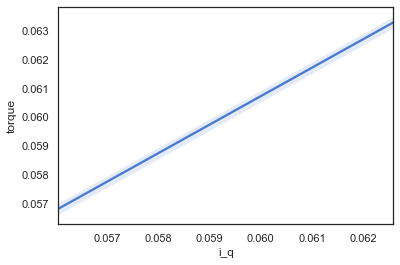

In [22]:
sns.regplot(x = 'i_q', y = 'torque', data = df_1, scatter = False)

When zoomed in on the mean. this linear regression line seems to be well fit to the data.  The band of error is very small near the mean, showing that most datapoints lie very close to the line of best fit.  

Lets find its equation and coefficient of determination (R squared value).  


In [23]:
def best_fit_slope_and_intercept(x_val, y_val):
    m = (((np.mean(x_val)*np.mean(y_val)) - np.mean(x_val*y_val)) / ((np.mean(x_val)**2) - np.mean(x_val**2))) #calculate the slope
    
    b = np.mean(y_val) - m*np.mean(x_val) #calculate the y intercept
    
    return m, b

In [24]:
def squared_error(y_orig, y_line):
    return sum((y_line - y_orig) * (y_line - y_orig)) #return the squared error between datapoints and the regression line

In [25]:
def coefficient_of_determination(y_orig, y_line):
    
    y_mean_line = [np.mean(y_orig) for y in y_orig] #find the mean y value
    squared_error_regr = squared_error(y_orig, y_line) #find the squared error between datapoints and the regression line
    squared_error_y_mean = squared_error(y_orig, y_mean_line) #find the squared error between datapoints and the mean y value
                                         
    return 1 - (squared_error_regr/squared_error_y_mean)

Here I create a method that uses linear regression to calculate the slope, intercept, and coefficient of determination for the line of best fit.  

In [26]:
df_sample = df_1.sample(frac=0.001) #sample 0.1% of the datapoints to reduce runtime
x_val = df_sample['i_q'] #the current, i_q, is the independent variable 
y_val = df_sample['torque'] #the torque is the dependent variable 

m, b = best_fit_slope_and_intercept(x_val, y_val) #find slope and y intercept for the regression line

regression_line = [(m * x) + b for x in x_val] #provide an array of points on the regression line

r_squared = coefficient_of_determination(y_val, regression_line) #find the coefficient of determination by comparing datapoints to their corresponding point on the regression line

print('y = {} * x + {}  r^2 = {}'.format(m, b, r_squared))

y = 0.9935625555294609 * x + -0.0001375687753901525  r^2 = 0.9931752680474168


A line that is approximately the identity is the best fit.  The coefficient of determination (R squared) is very close to one, so the majority of variance is predictable from i_q.  

### Answer 2

i_q is a very good predictor of torque because r squared is very close to 1.

We can reject the null hypothesis that torque is not well approximated by a linear relationship to i_q.  The r squared value is very close to 1 so the majority proportion of the variance in the torque is predictable from i_q.

How about u_d, is this measurement also a good predictor of torque? how does it compare to i_q?

(-1.7, 2.3)

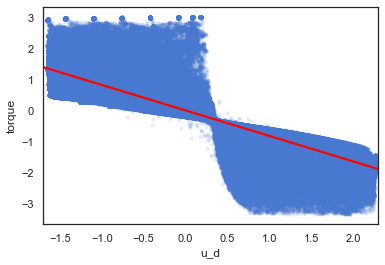

In [27]:
sns.regplot(x = 'u_d', y = 'torque', data = df_1, scatter = True, scatter_kws = {'alpha': 0.1}, line_kws = {'color': 'red'}, marker = '.')
plt.xlim(-1.7, 2.3)

The scatterplot above has many datapoints far from the regression line.  However, since there are so many datapoints in this dataset, those could only represent a small fraction of the population.  Lets look closer.  

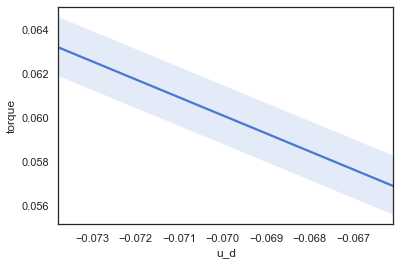

In [28]:
sns.regplot(x = 'u_d', y = 'torque', data = df_1, scatter = False)

When zoomed in on the mean, this linear regression line has a much larger band of error than the previous model. While it could still be a decent predictor of future values, i_q certainly will produce more precise results than u_d for predicting values.  

In [29]:
df_sample = df_1.sample(frac=0.001)
x_val = df_sample['u_d']
y_val = df_sample['torque']

m, b = best_fit_slope_and_intercept(x_val, y_val)

regression_line = [(m * x) + b for x in x_val]

r_squared = coefficient_of_determination(y_val, regression_line)

print('y = {} * x + {}  r^2 = {}'.format(m, b, r_squared))

y = -0.82830281062522 * x + 0.014210212913197282  r^2 = 0.6657212186933479


u_q is not as good a predictor of torque.  The R squared value for the line of best fit is ~ 0.7, compared to 0.99 for i_q.  Thus, some variance in the datapoints will not be predicted by u_q.  

i_q is the better choice for predicting future torque values.  

## Temperature Correlations

Temperature readings are taked from many different parts of the motor.  The ambient temperature is likely taken from the air around the motor while the coolant temparature would be taken at the heat exchanger after coolant has passed through the motor.  Stator yoke temparature is read at the frame of the stator, the stator teeth point off the frame towards the rotor, and wiring is wound around the teeth to create the electromagnet.  Lastly, permanent magnet temperature (pm) is measured on the spinning rotor where the permanant magnets are accelerated by the electromagnet winding on the stator.  

The coolant is passed through some part of the motor to pull heat away.  Perhaps we can determine which part of the motor has the highest correlation with coolant temperature and thus which part of the motor coolant likely passed through and took heat from.  

<img src="Dataset zips/electric-motor-temperature/Brushless-motor-main-parts-a-stator-and-a-rotor-768x590.png">

Source: https://howtomechatronics.com/how-it-works/how-brushless-motor-and-esc-work/


### Question 3

Which temperature reading has the highest correlation with coolant temperature, stator_yoke, stator_tooth, stator_winding, or pm (rotor temp)?

Specifically, we will investigate the coefficient of determination for the line of best fit between coolant temperature, and each of the 4 temperature readings on the motor.  Whichever has the highest R squared value is most strongly correlated with coolant temperature.  


In [30]:
df[['coolant', 'stator_yoke', 'stator_tooth', 'stator_winding', 'pm']].corr()

,coolant,stator_yoke,stator_tooth,stator_winding,pm
coolant,1.000000,0.874037,0.689003,0.509298,0.430548
stator_yoke,0.874037,1.000000,0.949898,0.845144,0.695014
stator_tooth,0.689003,0.949898,1.000000,0.965633,0.768352
stator_winding,0.509298,0.845144,0.965633,1.000000,0.729561
pm,0.430548,0.695014,0.768352,0.729561,1.000000


By examining the correlation coefficients above, we can see that stator_yoke has the highest correlation with coolant temperature.  We can investigate that line of best fit more closely.  

(-2.1, 2.4)

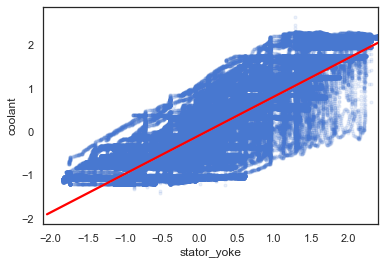

In [32]:
sns.regplot(x = 'stator_yoke', y = 'coolant', data = df_1, scatter = True, scatter_kws = {'alpha': 0.1}, line_kws = {'color': 'red'}, marker = '.')
plt.xlim(-2.1, 2.4)

There seems to be some positive linear relationship between coolant and stator_yoke.  The values have fairly high variance, but that may simply be due to the large number of datapoints crowding the scatterplot.  The regression line appears to be right through the middle of the datapoints.

Lets zoom in again to see the band of error near the mean.  

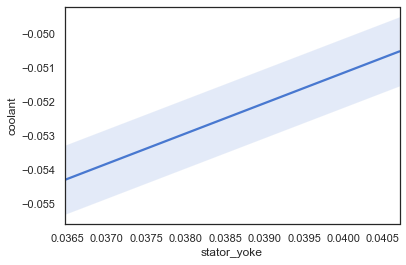

In [33]:
sns.regplot(x = 'stator_yoke', y = 'coolant', data = df_1, scatter = False)

As expected, there is a fairly large band of error.  However, predicting temperatures is expected to have higher variance, so this is likely the best correlation we are going to see.


In [34]:
df_sample = df_1.sample(frac=0.001)
x_val = df_sample['stator_yoke']
y_val = df_sample['coolant']

m, b = best_fit_slope_and_intercept(x_val, y_val)

regression_line = [(m * x) + b for x in x_val]

r_squared = coefficient_of_determination(y_val, regression_line)

print('y = {} * x + {}  r^2 = {}'.format(m, b, r_squared))

y = 0.8962012544757494 * x + -0.05180255510077175  r^2 = 0.7996200789670077


The coefficient of determination is approximately 0.78.  This value is not especially close to 1, so there may be a better predictor of coolant temperature, but it is still above 0.5 so there is still a majority of variance that can be predicted by stator yoke temperature.  Lets compare stator yoke to the other temperature readings and see which has the highest coefficient of determination.  

(-2.1, 2.4)

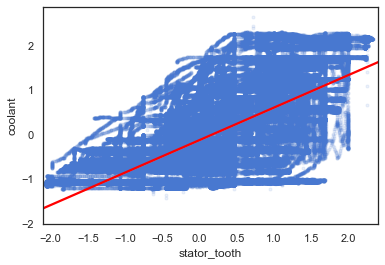

In [40]:
sns.regplot(x = 'stator_tooth', y = 'coolant', data = df_1, scatter = True, scatter_kws = {'alpha': 0.1}, line_kws = {'color': 'red'}, marker = '.')
plt.xlim(-2.1, 2.4)

In [35]:
df_sample = df_1.sample(frac=0.001)
x_val = df_sample['stator_tooth']
y_val = df_sample['coolant']

m, b = best_fit_slope_and_intercept(x_val, y_val)

regression_line = [(m * x) + b for x in x_val]

r_squared = coefficient_of_determination(y_val, regression_line)

print('y = {} * x + {}  r^2 = {}'.format(m, b, r_squared))

y = 0.7525450835727976 * x + -0.0997795815359485  r^2 = 0.5410189864129272


(-2.1, 2.4)

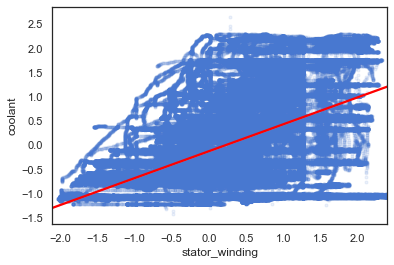

In [41]:
sns.regplot(x = 'stator_winding', y = 'coolant', data = df_1, scatter = True, scatter_kws = {'alpha': 0.1}, line_kws = {'color': 'red'}, marker = '.')
plt.xlim(-2.1, 2.4)

In [36]:
df_sample = df_1.sample(frac=0.001)
x_val = df_sample['stator_winding']
y_val = df_sample['coolant']

m, b = best_fit_slope_and_intercept(x_val, y_val)

regression_line = [(m * x) + b for x in x_val]

r_squared = coefficient_of_determination(y_val, regression_line)

print('y = {} * x + {}  r^2 = {}'.format(m, b, r_squared))

y = 0.601258711136207 * x + -0.06417805679234445  r^2 = 0.33822745619337813


(-2.1, 2.4)

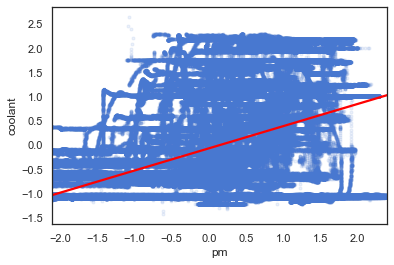

In [42]:
sns.regplot(x = 'pm', y = 'coolant', data = df_1, scatter = True, scatter_kws = {'alpha': 0.1}, line_kws = {'color': 'red'}, marker = '.')
plt.xlim(-2.1, 2.4)

In [37]:
df_sample = df_1.sample(frac=0.001)
x_val = df_sample['pm']
y_val = df_sample['coolant']

m, b = best_fit_slope_and_intercept(x_val, y_val)

regression_line = [(m * x) + b for x in x_val]

r_squared = coefficient_of_determination(y_val, regression_line)

print('y = {} * x + {}  r^2 = {}'.format(m, b, r_squared))

y = 0.49744720981530577 * x + -0.02105705710778591  r^2 = 0.25749402691710876


The analysis for stator winding, stator tooth, and permanent magnet temperature shows that they all have coefficients of determination lower than stator yoke when compared to coolant temperature.  The permanent magnet temperature in particular has almost no correlation with coolant temperature.  

### Answer 3

Of the 4 temperature readings on the motor, stator_yoke has the highest coefficient of determination when compared to coolant temperature at approximately 0.78.  Thus, these two readings have a high correlation and it can be inferred that the coolant takes most of its heat from the yoke of the stator.  

The permanent magnet temperature (pm) has the lowest coefficient of determination (~0.25) and thus lowest correlation. This is likely because the permemanent magnets are on the rotating part of the motor where it is difficult to pump coolant.

Thus, if the stator yoke is exceeding target temperatures, increasing coolant flow would be an effecive strategy for cooling the stator.  

Conversely, if the permament magnet temperature on the rotor is exceeding targets, changing the coolant flow will not likely have a significant effect.  A different strategy is required.  

## Future Questions

### Idea 1

Do any of the input measurements cluster around specific values?  Perhaps the experiements were designed with some bias towards certain voltage or current values and underrepresent the values in between.  Or perhaps certain values are easier to produce from an electrical engineering perspective.  We could use k-means clustering to see if i_d, i_q, u_d, or u_q have any clustering instead of smooth distributions.  From looking at the histograms earlier, I think u_d would be interesting to run a clustering algorithm on. Certain ranges of values seem to have a higher occurance throughout the distribution. 

Not great for continuous data

### Idea 2

However, clustering is not especially useful for continuous data.  Instead, we could try to reduce the number of dimensions. A dimensionality reduction algorithm could find latent features that are related to the original features.  One possibility is a reduction algorithm finding that multiplying current and voltage together will provide a value that can be used to make predictions.  From my physics background, I know this calculation would result in the power (current * voltage).  The power put into the motor may be a strong predictor for the torque or temperature.

Singular Value Decomposition (SVD) 
Principle Components Analysis (PCA)
Autoencoders
Taking multiple input features and reducing them to one column
Capture all variants from many feature in one feature component

### Idea 3

Could we use a neural network to receive all characteristics of the motor (u_q u_d, i_q, i_d, motor speed, torque) and predict temperatures in the various parts of the motor (stator, rotor, coolant, ambient)?  Predicting the rotor temperature from some combination of inputs would be especially useful since the rotor is the most difficult part of the motor to monitor. 
Define the impact of predicting these values.



